In [1]:
import HelperFuncs as hfuncs
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.data_utils import Sequence

Using TensorFlow backend.


We're going to first try training a CNN on the individual images.
We will be using binary cross entropy across the 17 regions.

In [ ]:
BATCH_SIZE = 20
FINAL_WIDTH = 400
FINAL_HEIGHT = 600
CHANNELS = 1
ZONES = 17
BUCKET_NAME = 'miscdatastorage'
DATA_DIR = 'DHSData/'
TEMP_DIR = 'temp'
LABELS_DIR = r'stage1_labels.csv'
EXTENSION = '.a3daps'
np.random.seed(0)

#Define a generator function
class myGenerator:
    #AWS and Directory information 
    bucketName = BUCKET_NAME
    dataDir = DATA_DIR
    temp_dir = TEMP_DIR
    labels_dir = LABELS_DIR
    #Connect to AWS
    key_id, secret_key = hfuncs.GetAWSCredentials()
    client = hfuncs.GetAWSClient(key_id,secret_key)
    bucket = client.Bucket(bucketName)
    extension = EXTENSION
    #labels and keys
    labels_dict = hfuncs.GetLabelsDict(labels_dir)
    key_ary = None
    #Batch information
    n_samples = 0
    batch_size = 0
    #Requester
    batch_requester = None
    #Initialize required parameters
    def __init__(self,keys,n_samples,batch_size=BATCH_SIZE):
        self.key_ary = keys
        self.n_samples = n_samples
        self.batch_size = batch_size
        #Initialize AWS Batch Requester
        self.batchrequester = hfuncs.BatchRequester(self.bucket,self.key_ary,self.labels_dict,self.dataDir,self.temp_dir,self.extension)
    def GenerateSamples(self):
        '''Returns generator that retireves n_sample scans at a time,
        mixes each scan-slice image into a meta-batch, and returns mini-batches of 
        BATCH_SIZE'''
        #While there is data left, yield batch
        while self.batchrequester.DoItemsRemain():
            #Request data
            print("Retrieving data..")
            X,y = self.batchrequester.NextBatch(self.n_samples)
            n_angles = X.shape[3] #num angles (64)

            #Create efficient mapping for mixing and indexing batch data
            indexing_dict = {}
            order = np.arange(X.shape[0]*n_angles)
            np.random.shuffle(order)
            k = 0
            for s in range(X.shape[0]):
                for a in range(n_angles):
                    indexing_dict[order[k]]=[s,a]
                    k+=1

            print("Data retrieved and indexing computed.")

            #Initialize output arrays
            print("Initializing arrays...")
            X_train = np.zeros((X.shape[0]*n_angles,FINAL_WIDTH,FINAL_HEIGHT,CHANNELS))
            y_train = np.zeros((X.shape[0]*n_angles,ZONES))
            print("Arrays initialized")

            #Set counter to 0, channel to 1
            chan = 0 #No need to iterate here
            i = 0
            #Clean each image and store it in output
            while i < X.shape[0] * n_angles:
                j = i
                while j < i+BATCH_SIZE:
                    s,a = indexing_dict[j]                    
                    X_train[j,:,:,chan] = hfuncs.CropCleanResize(X[s,:,:,a],FINAL_WIDTH,FINAL_HEIGHT)
                    y_train[j,:] = y[s,:]
                    j += 1
                yield X_train[i:i+BATCH_SIZE,:,:,:],y_train[i:i+BATCH_SIZE]
                i += BATCH_SIZE


def CleanKeyAry(key_ary,labels_dict,dataDir,extension):
    '''Taken from the BatchRequester class'''
    key_ary_new=[]
    for key in key_ary:
        img_id = key.strip().replace(dataDir,'').replace(extension,'')
        if img_id in labels_dict.keys():
            key_ary_new.append(key)
        else:
            continue
    return key_ary_new

def getTrainTestValData(labels_dir=LABELS_DIR,extension=EXTENSION,dataDir=DATA_DIR,bucketName=BUCKET_NAME):
    '''Retrieves all samples that have corresponding labels 
    and splits data into a train, test, val set. '''
    #Labels        
    labels_dict = hfuncs.GetLabelsDict(labels_dir)
    
    #AWS Bucket
    key_id, secret_key = hfuncs.GetAWSCredentials()
    client = hfuncs.GetAWSClient(key_id,secret_key)
    bucket = client.Bucket(bucketName)
    
    #Get shuffled keys and separate into train,test,and validation
    key_ary = hfuncs.GetShuffledKeys(bucket)
    key_ary = CleanKeyAry(key_ary,labels_dict,dataDir,extension)
    K_train,K_test = train_test_split(key_ary,test_size=0.20,random_state=0)
    K_train,K_val = train_test_split(K_train,test_size=0.25,random_state=0) #0.80*0.25 = 0.20 validation 
    
    return K_train,K_test,K_val     
    

In [ ]:
import h5py
import os


#Connect to aws s3
UPLOAD_BUCKET = 'cleandhsdata'
key_id, secret_key = hfuncs.GetAWSCredentials()
client = hfuncs.GetAWSClient(key_id,secret_key)
bucket = client.Bucket(UPLOAD_BUCKET)

#Separate data
K_train,K_test,K_val = getTrainTestValData()

trainGen = myGenerator(K_train,25)
i = 0
for X, y in trainGen.GenerateSamples():
    filename = os.path.join(TEMP_DIR,"batch_{}.hdf5".format(i))
    key = "train/{}".format("batch_{}.hdf5".format(i))
    with h5py.File(filename,"w") as f:
        dset = f.create_dataset('image',data=X)
        dset2 = f.create_dataset('labels',data=y)
    bucket.upload_file(Filename=filename,Key=key)
    os.remove(filename)
    i += 1

Retrieving data..
Something went wrong. Skipping aaaf2adedb6f97d6c53a7fd5955fcecd
Something went wrong. Skipping 24fc2fdeb799e97fea387b2ba06b8680
Data retrieved and indexing computed.
Initializing arrays...
Arrays initialized


In [ ]:
trainGen = myGenerator(K_val,25)
i = 0
for X, y in trainGen.GenerateSamples():
    filename = os.path.join(TEMP_DIR,"batch_{}.hdf5".format(i))
    key = "val/{}".format("batch_{}.hdf5".format(i))
    with h5py.File(filename,"w") as f:
        dset = f.create_dataset('image',data=X)
        dset2 = f.create_dataset('labels',data=y)
    bucket.upload_file(Filename=filename,Key=key)
    os.remove(filename)
    i += 1

In [ ]:
trainGen = myGenerator(K_test,25)
i = 0
for X, y in trainGen.GenerateSamples():
    filename = os.path.join(TEMP_DIR,"batch_{}.hdf5".format(i))
    key = "test/{}".format("batch_{}.hdf5".format(i))
    with h5py.File(filename,"w") as f:
        dset = f.create_dataset('image',data=X)
        dset2 = f.create_dataset('labels',data=y)
    bucket.upload_file(Filename=filename,Key=key)
    os.remove(filename)
    i += 1

In [21]:
path = "temp/batch_3.hdf5"
key = "train/batch_3.hdf5"
from matplotlib import pyplot as plt

with open(path,"w+b") as f:
    bucket.download_fileobj(key,f)
with h5py.File(path,"r") as f:
    print(f.name)
    for name in f:
        print(name)
    image = f['/image'].value
    labels = f['/labels'].value


/
image
labels


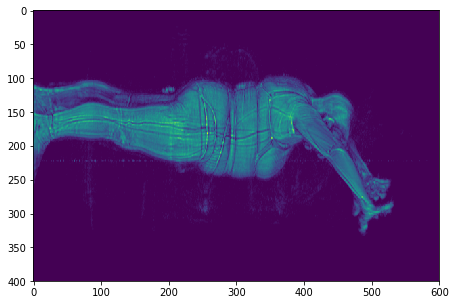

In [23]:
%matplotlib inline
fig = plt.figure(figsize = (16,16))
ax = fig.add_subplot(121)
ax.imshow(image[5,:,:,0], cmap = 'viridis')